# SciPy based transforms

In the last notebook `getting_started_with_robot_ik.ipynb` we have familiarized ourselves with the concept of Forward and Inverse Kinematics (IK) and implemented a simple IK solver for a 3DOF leg using trigonometry. In this notebook we will use SciPy to implement a more advanced IK solver.

SciPy, a Python library built upon NumPy, provides a wide array of mathematical algorithms and functions that are valuable for robotics, including linear algebra, which is of interest here.

The first step is to convert our forward kinematics code from custom Points and hand crafted function to use matrix transforms for rotation and translation.

Alongside the conversion, we are going to bring all the algorithms to work in full 3D space, not just 2D projections.

In [1]:
# Enable python modules live reloading
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from point import Point3D, Line3D, Leg3D

def forward_kinematics(
    coxa_length, femur_length, tibia_length, alpha, beta, gamma, start_height=2, body_length=5
):
    # Define initial points in local coordinates
    start_point = Point3D([0, start_height, 0])
    body_local = Point3D([body_length, 0, 0])
    coxa_local = Point3D([coxa_length, 0, 0])
    femur_local = Point3D([femur_length, 0, 0])
    tibia_local = Point3D([tibia_length, 0, 0])

    # Create rotation matrices
    rotation_axis = np.array([0, 0, 1])
    r_alpha = R.from_rotvec(rotation_axis * alpha, degrees=True)
    r_beta = R.from_rotvec(rotation_axis * beta, degrees=True)
    r_gamma = R.from_rotvec(rotation_axis * gamma, degrees=True)

    # Calculate global positions using transformations
    body_point = start_point + body_local

    # Apply alpha rotation to coxa
    coxa_rotated = r_alpha.apply(coxa_local.numpy())
    coxa_point = body_point + coxa_rotated

    # Apply alpha+beta rotation to femur
    r_alpha_beta = r_alpha * r_beta
    femur_rotated = r_alpha_beta.apply(femur_local.numpy())
    femur_point = coxa_point + femur_rotated

    # Apply alpha+beta+gamma rotation to tibia
    r_alpha_beta_gamma = r_alpha_beta * r_gamma
    tibia_rotated = r_alpha_beta_gamma.apply(tibia_local.numpy())
    tibia_point = femur_point + tibia_rotated

    # Set  Point labels for visualization
    body_point.label = rf'$\alpha$={alpha}°'
    coxa_point.label = rf'$\beta$={beta}°'
    femur_point.label = rf'$\gamma$={gamma}°'
    tibia_point.label = 'Foot'

    # Return lines connecting the points
    return Leg3D([
        Line3D(start_point, body_point, 'Body'),
        Line3D(body_point, coxa_point, 'Coxa'),
        Line3D(coxa_point, femur_point, 'Femur'),
        Line3D(femur_point, tibia_point, 'Tibia'),
    ])


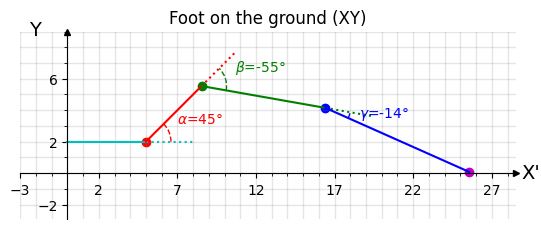

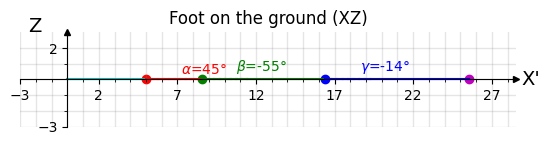

In [3]:
%matplotlib inline

from plotting import plot_leg_with_points

coxa_length = 5
femur_length = 8
tibia_length = 10


model = forward_kinematics(coxa_length, femur_length, tibia_length, 45, -55, -14)

_ = plot_leg_with_points(model.xy, 'Foot on the ground (XY)', link_labels='none', x_label="X'", y_label='Y')
_ = plot_leg_with_points(model.xz, 'Foot on the ground (XZ)', link_labels='none', x_label="X'", y_label='Z')

This was a good start, but code is hard to read and understand due to excessive repetitions. Let's introduce a transform system, similar to the one used in ROS TF2 library.

With this `Transform` class we can now create a chain of transformations instead of hand crafting them.

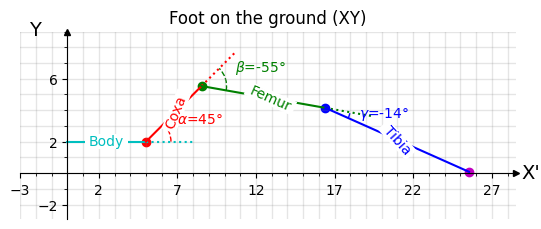

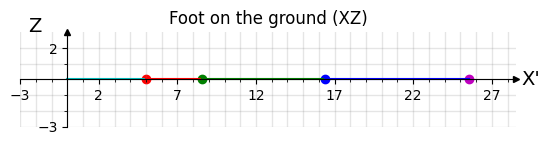

In [ ]:
class Transform:
    def __init__(self, matrix):
        self._matrix = matrix

    @classmethod
    def make(self, rotation, translation):
        return Transform(
            np.block(
                [
                    [rotation.as_matrix(), np.array(translation).reshape(3, 1)],
                    [np.zeros(3), 1],
                ]
            )
        )

    @classmethod
    def from_rotvec(self, rotvec, degrees=False):
        return Transform.make(R.from_rotvec(rotvec, degrees=degrees), [0, 0, 0])

    @classmethod
    def from_translation(self, translation):
        return Transform.make(R.identity(), translation)

    @property
    def rotation(self):
        return self._matrix[:3, :3]

    @property
    def translation(self):
        return self._matrix[:3, 3]

    def apply_point(self, point):
        return Point3D(self.apply_nd(point.numpy()))

    def apply_nd(self, nd_point):
        point4d = np.append(nd_point, 1)
        transformed_point = self._matrix @ point4d
        return transformed_point[:3]

    # operator @
    def __matmul__(self, other):
        return Transform(self._matrix @ other._matrix)

    def __repr__(self):
        rotation = R.from_matrix(self.rotation).as_rotvec(degrees=True)
        translation = self.translation
        return f'Transform({translation=}, {rotation=}, as matrix:\n{self._matrix})'


def forward_kinematics_transforms(
    coxa_length,
    femur_length,
    tibia_length,
    alpha,
    beta,
    gamma,
    start_height=2,
    body_length=5,
    body_rotation=0,
    verbose=False,
):
    identity_point = Point3D([0, 0, 0])

    # Create rotation matrices and transforms
    rotation_axis = np.array([0, 0, 1])
    r_identity = R.from_rotvec(rotation_axis * 0, degrees=True)
    start_transform = Transform.from_translation([0, start_height, 0])


    body_joint = start_transform @ Transform.from_rotvec(rotation_axis * body_rotation, degrees=True)
    body_link = body_joint @ Transform.make(r_identity, [body_length, 0, 0])

    coxa_joint = body_link @ Transform.from_rotvec(rotation_axis * alpha, degrees=True)
    coxa_link = coxa_joint @ Transform.make(r_identity, [coxa_length, 0, 0])

    femur_joint = coxa_link @ Transform.from_rotvec(rotation_axis * beta, degrees=True)
    femur_link = femur_joint @ Transform.make(r_identity, [femur_length, 0, 0])

    tibia_joint = femur_link @ Transform.from_rotvec(rotation_axis * gamma, degrees=True)
    tibia_link = tibia_joint @ Transform.make(r_identity, [tibia_length, 0, 0])

    # Calculate global positions using transformations
    start_point = start_transform.apply_point(identity_point)

    body_point = body_link.apply_point(identity_point)
    body_point.label = rf'$\alpha$={alpha}°'

    coxa_point = coxa_link.apply_point(identity_point)
    coxa_point.label = rf'$\beta$={beta}°'

    femur_point = femur_link.apply_point(identity_point)
    femur_point.label = rf'$\gamma$={gamma}°'

    tibia_point = tibia_link.apply_point(identity_point)
    tibia_point.label = 'Foot'

    result = Leg3D(
        [
            Line3D(start_point, body_point, 'Body'),
            Line3D(body_point, coxa_point, 'Coxa'),
            Line3D(coxa_point, femur_point, 'Femur'),
            Line3D(femur_point, tibia_point, 'Tibia'),
        ]
    )

    if verbose:
        print(f'{start_point=}')
        print(f'{body_point=}')
        print(f'{coxa_point=}')
        print(f'{femur_point=}')
        print(f'{tibia_point=}')
        for line in result:
            print(line)

    return result

model = forward_kinematics_transforms(coxa_length, femur_length, tibia_length, 45, -55, -14)

_ = plot_leg_with_points(
    model.xy, 'Foot on the ground (XY)', link_labels='inline', x_label="X'", y_label='Y'
)
_ = plot_leg_with_points(
    model.xz,
    'Foot on the ground (XZ)',
    link_labels='none',
    joint_labels='points',
    x_label="X'",
    y_label='Z',
)
